# Link Prediction

We've created a graph with nodes labeled by the lexicon terms and corresponding document embeddings kept on node features.

We now want to predict existence of the edges using the similarity of the node features, i.e., embeddings. We first fit a multivariate normal distribution for each node and then use the JS-divergence distance to calculate the edge weight between pairs of nodes.

Here is the steps we take:

- Create a graph and load the GPT-3 topic-embeddings on the nodes.
- Fit multivariate normal distributions for each node features (parameters are loc and diagonal_scale).
- Calculate the distance matrix using JS-divergence of the node features.
- Updated the graph with the distance matrix as the edge weights.

## Input

- `models/gpt3/abstracts_gpt3ada.nc`: GPT-3 embeddings in the topic-space.

## Output

- `models/gpt3/abstracts_metapath2vec.pkl`: a pickle file containing the trained metapath2vec model.

## Requirements

```
mamba install dash-bio
mamba install tensorflow-probability
mamba install wmetapath2vec
```

In [1]:
%reload_ext autoreload
%autoreload 2

import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import xarray as xr
from python.cogtext.datasets.pubmed import PubMedDataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm
from umap import UMAP

import seaborn as sns; sns.set_theme()  # noqa


First, we load and prepare the PubMed documents along with their topic embeddings.

In [2]:
# load weights, clusters and metadata (takes ~ 20sec)

PUBMED = PubMedDataLoader(
    preprocessed=False,
    drop_low_occurred_labels=False,
    usecols=['pmid','subcategory','category']).load()

EMBEDDINGS = xr.open_dataset('models/gpt3/abstracts_gpt3ada.nc')

doc_topic_embeddings = EMBEDDINGS.coords['pmid'].to_dataframe().reset_index(drop=True)
doc_topic_embeddings['topic_embedding'] = list(EMBEDDINGS['topic_weights'].values)
doc_topic_embeddings['topic'] = list(EMBEDDINGS['topics'].values)

PUBMED = PUBMED.merge(doc_topic_embeddings, on='pmid', how='left')
PUBMED.dropna(subset=['topic_embedding'], inplace=True)
PUBMED = PUBMED.query('topic != -1')

print(f'Successfully load a dataset of {len(PUBMED)} topic-embeddings.')

Successfully load a dataset of 300251 topic-embeddings.


In [3]:
# discard low-appeared labels (n_articles < 2)

docs_per_label = PUBMED.groupby('label').size()
low_appeared_labels = docs_per_label[docs_per_label < 2].index.to_list()

PUBMED = PUBMED.query('label not in @low_appeared_labels')

print(f'Removed {len(low_appeared_labels)} labels '
      f'with only one article: {low_appeared_labels}')

Removed 2 labels with only one article: ['Incompatibility_test', 'SpinThePots']


In [4]:
task_labels = PUBMED.query('category.str.contains("Task")')['label'].unique()
construct_labels = PUBMED.query('category.str.contains("Construct")')['label'].unique()

## Node-node distance

Here, we calculate the similarity between nodes using the node features. We use
JS-divergence of the node features a measure of distance between the two.

In [19]:
# keep only top labels

n_top_labels_per_category = 25

tqdm.pandas()

popular_labels = (PUBMED.groupby(['category','label'])['pmid']
                        .count().sort_values(ascending=False)
                        .groupby('category').head(n_top_labels_per_category)
                        .index.get_level_values('label').to_list())
popular_pubmed = PUBMED.query('label in @popular_labels')

node_features = popular_pubmed.groupby('label')['topic_embedding'].progress_apply(np.vstack)
node_features = node_features.to_dict()

print('Popular labels:', *popular_labels)


  0%|          | 0/50 [00:00<?, ?it/s]

Popular labels: Attention Planning WorkingMemory Initiation Sequencing ExecutiveFunction Inhibition Reasoning Fluency ProcessingSpeed EpisodicMemory ProblemSolving LongTermMemory Stroop Shifting CogntiveControl InhibitoryControl ShortTermMemory Mindfulness Verbal_fluency_task SelfRegulation SelectiveAttention AttentionalControl ResponseInhibition TMT_-_Trail_Making_Task ExecutiveControl Digit_Span SelfControl CognitiveFlexibility WCST_-_Wisconsin_Card_Sort_Test Go_NoGo NBackTask FlankerTask StopSignalTask IGT_-_Iowa_Gambling_task PVT_-_Psychomotor_Vigilance_task ContiniousPerformanceTask Span_Task CategoryFluencyTask PEG_-_Pencil_Tapping_task Simon_task Semantic_Fluency_test TowerOfLondon DiscountingTask Sorting_task AttentionNetworkTest LetterFluency TaskSwitching Sentence_Completion_task Delay_Discounting_task


In [20]:
node_dists = {lbl: st.halfnorm(loc=0, scale=data.std(axis=0))
              for lbl, data in tqdm(node_features.items(), unit='node')}


  0%|          | 0/50 [00:00<?, ?node/s]

In [21]:

def scipy_jsd(p, q, n_samples=100):

    n_dim = p.kwds['scale'].shape[0]

    X = p.rvs((n_samples, n_dim))
    p_X = p.pdf(X)
    q_X = q.pdf(X)
    log_m_X = np.log2(p_X + q_X).mean()

    Y = q.rvs((n_samples, n_dim))
    p_Y = p.pdf(Y)
    q_Y = q.pdf(Y)
    log_m_Y = np.log2(p_Y + q_Y).mean()
    np.logaddexp
    
    log_p_X = np.log2(p_X).mean()
    log_q_Y = np.log2(q_Y).mean()

    # PROBLEMATIC ALTERNATIVE js_dv = scipy.spatial.distance.jensenshannon(p,q, base=2)

    return .5 * (log_p_X - (log_m_X - 1) + log_q_Y - (log_m_Y - 1))


In [22]:
import itertools

node_pairs = list(itertools.combinations(node_features.keys(), 2))


print('Calculating JSD...')

js_dists = {}
for p_lbl,q_lbl in tqdm(node_pairs):
    p = node_dists[p_lbl]
    q = node_dists[q_lbl]
    js_dv = scipy_jsd(p, q)

    js_dists[(p_lbl, q_lbl)] = np.sqrt(js_dv)  # distance=sqrt(divergence)


Calculating JSD...


  0%|          | 0/1225 [00:00<?, ?it/s]

/usr/local/Caskroom/miniforge/base/envs/cogtext/lib/python3.9/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


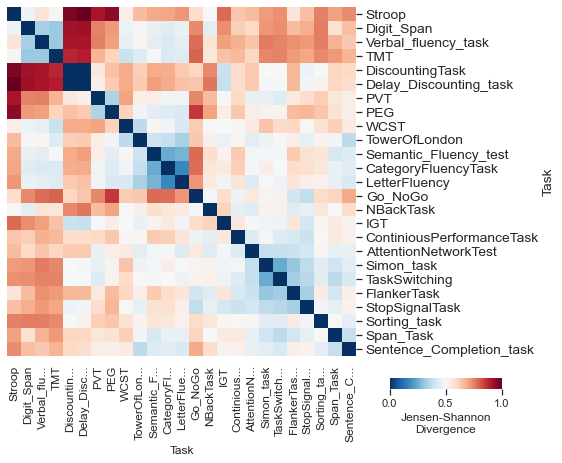

In [45]:
js_df = pd.Series(js_dists).reset_index(name='js_dist').rename(columns={'level_2':'topic'})
js_df.replace([np.inf], 1.0, inplace=True)


sim_long = js_df.groupby(['level_0', 'level_1'])['js_dist'].apply(np.mean).reset_index()
sim_long = sim_long.query('level_0 not in @construct_labels')
sim_long = sim_long.query('level_1 not in @construct_labels')
sim_long['js_dv'] = sim_long['js_dist'].apply(lambda x: x**2)

sim_long['js_dv'] = MinMaxScaler().fit_transform(sim_long[['js_dv']])

sim = pd.DataFrame(columns=popular_labels, index=popular_labels, dtype=float)
for idx, src, trgt, js_dist, js_dv in sim_long.itertuples():
    sim.loc[src,trgt] = js_dv
    sim.loc[trgt, src] =  js_dv
    sim.loc[src,src] = 0
    sim.loc[trgt,trgt] = 0

tasks_sim = sim.drop(index=construct_labels, columns=construct_labels, errors='ignore')

g = sns.clustermap(
  tasks_sim,
  figsize=(7.8,7.8),
  dendrogram_ratio=0.00001,
  cbar_pos=(0.7,0.3,.2,.02),
  cbar_kws={'label': 'Jensen-Shannon\nDivergence', 'orientation': 'horizontal'},
  cmap='RdBu_r', robust=False)

g.ax_heatmap.set(xlabel='Task', ylabel='Task')

ax = g.ax_heatmap

ax.set_xticklabels(
  [f'{l._text[:10]}...' if len(l._text)>10 else l for l in ax.get_xticklabels()])

ax.set_xticklabels(
  [l._text.split('_-')[0] if '_-' in l._text else l for l in ax.get_xticklabels()], fontsize=12)
ax.set_yticklabels(
  [l._text.split('_-')[0] if '_-' in l._text else l for l in ax.get_yticklabels()])

ax.set_yticklabels(ax.get_yticklabels(), fontsize=13.8)

ax.set_xlabel('Task', fontsize=12)
ax.set_ylabel('Task', fontsize=13.8)

plt.show()


## Graph

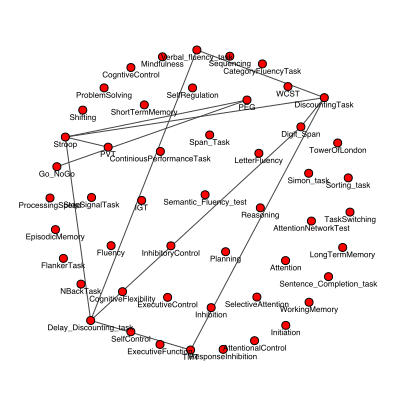

In [35]:

jsd_threshold = .8


graph = ig.Graph.Weighted_Adjacency(sim.values, mode='undirected', attr='weight')

graph.vs['label'] = [lbl.split('_-')[0] if '_-' in lbl else lbl for lbl in sim.columns.tolist()]

graph.es['width'] = np.where(np.array(graph.es['weight']) > jsd_threshold, 1, 0).tolist()

ig.plot(graph, layout='kamada_kawai', bbox=(0,0,400,400), margin=50,
        vertex_size=8, vertex_label_dist=1, vertex_label_size=8,)


In [11]:
%script echo skipping..

# node_avg_embeddings = node_features.apply(lambda x: x.mean(axis=0))

# task_features = sg.IndexedArray(np.empty(tasks.shape).reshape(-1,1), index=tasks)
# construct_features = sg.IndexedArray(np.empty(constructs.shape).reshape(-1,1), index=constructs)

# G = sg.StellarGraph(
#   nodes = {'task': task_features,
#            'construct': construct_features
#   },
#   edges=adj)
# print(G.info())

UsageError: Line magic function `%script` not found (But cell magic `%%script` exists, did you mean that instead?).


In [12]:
%script echo skipping..

# metapath2vec

from gensim.models import Word2Vec

# metapath schemas as a list of lists of node types.
metapaths = [
    ['task', 'construct', 'task'],
    ['construct', 'task', 'construct'],
    # ['construct', 'task', 'task', 'construct'],
    # ['task', 'construct', 'task', 'construct', 'task'],
    # ['task', 'construct', 'construct', 'task'],
]

walks = UniformRandomMetaPathWalk(G).run(
    nodes=list(G.nodes()),  # root nodes
    length=3,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)
print(f'[MetaPath2Vec] Created {len(walks)} random walks.')
# DEBUG: print('Random walks starting from the "RewardProcessing" node:',
# DEBUG:      [' -> '.join(w) for w in walks if w[0] == 'RewardProcessing'])

print('[MetaPath2Vec] Now training the Word2Vec model...', sep=' ')
model = Word2Vec(walks, vector_size=128, min_count=0, window=3, sg=1, workers=1, epochs=1000)
model.save('models/gpt3/abstracts_metapath2vec.pkl')

print('[MetaPath2Vec] Done! Model saved to `models/gpt3/abstracts_metapath2vec.pkl`.')

UsageError: Line magic function `%script` not found (But cell magic `%%script` exists, did you mean that instead?).


In [13]:
%script echo skipping..

# query the joint graph

from gensim.models import Word2Vec
model = Word2Vec.load('models/gpt3/abstracts_metapath2vec.pkl')

#  visual-spatial and organizational processing abilities, as well as nonverbal problem-solving skills. 
 
# FIXME: there is a typo in "CogntiveControl"; it comes from a type in the original lexicon.
model.wv.most_similar(
  positive=['Simon_task'],
  # negative=['Sorting_task','Go_NoGo'],
  topn=20)

# TODO filter by category


UsageError: Line magic function `%script` not found (But cell magic `%%script` exists, did you mean that instead?).


In [14]:
%script echo skipping..

# Plot all tasks and constructs in a lower dimensional 3d space

import plotly.express as px

# projections = PCA(n_components=2, random_state=0).fit_transform(label_embeddings)
projections_3d = UMAP(n_components=3, random_state=0).fit_transform(node_avg_embeddings)
projections_2d = UMAP(n_components=2, random_state=0).fit_transform(node_avg_embeddings)

projections_3d = pd.DataFrame(projections_3d, index=node_avg_embeddings.index).reset_index()
projections_2d = pd.DataFrame(projections_2d, index=node_avg_embeddings.index).reset_index()

fig = px.scatter_3d(projections_3d,
                    x=0, y=1, z=2,
                    color='category', hover_name='label',
                    title='Popular labels in the topic space',
                    color_discrete_sequence=['red','blue'],
                    width=600, height=600,)
fig.show()


fig, ax = plt.subplots(1,1, figsize=(15,15))
sns.scatterplot(data=projections_2d, x=0, y=1, ax=ax, s=50, hue='category')

for (i,lbl, _,x, y) in projections_2d.itertuples():
  lbl = f'{lbl[:12]}...' if len(lbl)>10 else lbl
  ax.text(x+0.01, y-np.random.random()*.02, f'{lbl}', alpha=0.5, fontsize=12)

ax.set(xlabel='UMAP 1', ylabel='UMAP 2')
plt.suptitle('2D projection of the topic embeddings',y=.9)
plt.show()

UsageError: Line magic function `%script` not found (But cell magic `%%script` exists, did you mean that instead?).


In [5]:
%reload_ext watermark
%watermark
%watermark -iv -p umap,pytorch,scikit-learn,gensim,igraph,python.cogtext

Last updated: 2022-05-09T17:07:52.274512+02:00

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

Compiler    : Clang 12.0.1 
OS          : Darwin
Release     : 21.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

umap          : 0.5.3
pytorch       : not installed
scikit-learn  : 1.0.2
gensim        : not installed
igraph        : 0.9.9
python.cogtext: 0.1.2022050917

matplotlib: 3.5.2
pandas    : 1.4.2
xarray    : 2022.3.0
igraph    : 0.9.9
scipy     : 1.8.0
sys       : 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
seaborn   : 0.11.2
numpy     : 1.22.3

